In [119]:
from scipy.stats import chi2_contingency

import torch
import matplotlib.pyplot as plt
import numpy as np 
import itertools
import statsmodels.api as sm

from spikeometric.models import BernoulliGLM
from spikeometric.datasets import NormalGenerator, ConnectivityDataset
from spikeometric.stimulus import RegularStimulus

from torch_geometric.data import Data
from torch_geometric.utils import to_dense_adj, to_networkx



### Test on spike data

In [198]:
n_neurons = 3
n_networks = 1

mu=0
sigma=10
theta = 5

# set up the neuron model
neuron_model = BernoulliGLM(
    theta=theta,
    dt=1.,
    coupling_window=4,
    abs_ref_scale=1,
    abs_ref_strength=-100,
    rel_ref_scale=0,
    rel_ref_strength=-30,
    alpha=0.5,
    beta=0.5
)

edge_index = torch.tensor([[0, 0],
                           [1, 2]])

W0 = torch.tensor([6.0, 7.5])

dataset = Data(num_nodes=3, W0=W0, edge_index=edge_index)

torch.save(dataset,'data/homemade.pt')
example_network = torch.load('data/homemade.pt')

#### Simulate

In [199]:
#stimulus_masks = torch.tensor([0, 0, 2], dtype=torch.bool) # stimulerer nevron 1
#stimulus = lambda t: 2*(t % 1000 < 200)*stimulus_masks
#neuron_model.add_stimulus(stimulus)

In [200]:
n_timesteps = 10**6
spikes = neuron_model.simulate(example_network, n_steps=n_timesteps, verbose=False)

#### Plot results

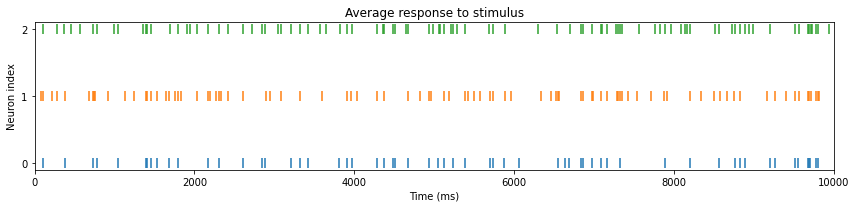

In [113]:
plt.figure(figsize=(12,3))

plt.scatter(np.where(spikes[0,:] == 1)[0], np.zeros_like(np.where(spikes[0,:] == 1)[0]), marker='|', s=100)
plt.scatter(np.where(spikes[1,:] == 1)[0], np.ones_like(np.where(spikes[1,:] == 1)[0]), marker='|', s=100)
plt.scatter(np.where(spikes[2,:] == 1)[0], 2*np.ones_like(np.where(spikes[2,:] == 1)[0]), marker='|', s=100)

plt.yticks([0,1,2])
plt.xlabel("Time (ms)")
plt.ylabel("Neuron index")
plt.xlim([0,10_000])
plt.ylim([-0.1,2.1])
plt.title("Average response to stimulus")
plt.tight_layout()
plt.show()

In [114]:
W0 = to_dense_adj(example_network.edge_index, edge_attr=example_network.W0, max_num_nodes=example_network.num_nodes)[0]
true_effect = torch.sigmoid(W0 - torch.tensor(theta)) - torch.sigmoid(-torch.tensor(theta))
print(true_effect)

tensor([[0.0000, 0.7244, 0.9174],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000]])


In [115]:
# simple test procedure:
## create an ordered list of the pairs of variables
## for each pair, make a contingency table and test for independence
### In principle, we should explore a range of time lags for each pair! For now, look at a single lag

## if we reject the null hypotesis, add a directed edge from , when I am looking at 

### Learn structure

In [118]:
n = 3 #num nodes
nodes = np.arange(0, n)
connections = [] #

for i in nodes:
    source = [i]
    targets = np.delete(nodes, i)
    connections += itertools.product(source, targets)

skeleton = connections.copy()
#print(connections)

for k in range(len(connections)):
    i, j = connections[k]
    
    target_spikes = torch.roll(spikes[j], -1) 
    source_spikes = spikes[i]
    
    # compute counts
    n_11 = torch.sum(target_spikes[source_spikes == 1] == 1) # both spike
    n_10 = torch.sum(target_spikes[source_spikes == 0] == 1) # only target spikes
    n_01 = torch.sum(target_spikes[source_spikes == 1] == 0) # only source spikes
    n_00 = torch.sum(target_spikes[source_spikes == 0] == 0) # none spike
    
    # contingency table
    table = np.array([[n_00, n_01], [n_10, n_11]])
    _, p, _, _ = chi2_contingency(table)
    
    print(f'({i}, {j}) | Ø', p < 0.05, p)
    if p >= 0.05:
        skeleton.remove((i, j))
        
    for c in nodes:
        if c != i and c!=j:
            
            conditional = np.where(torch.roll(spikes[c], -1) == 1)[0]
            target_spikes = torch.roll(spikes[j, conditional], -1) 
            source_spikes = spikes[i, conditional]

            n_11 = torch.sum(target_spikes[source_spikes == 1] == 1) # both spike
            n_10 = torch.sum(target_spikes[source_spikes == 0] == 1) # only target spikes
            n_01 = torch.sum(target_spikes[source_spikes == 1] == 0) # only source spikes
            n_00 = torch.sum(target_spikes[source_spikes == 0] == 0) # none spike

            # contingency table
            table = np.array([[n_00, n_01], [n_10, n_11]])
            
            #print(table)
            _, p, _, _ = chi2_contingency(table)
            print(f'({i}, {j}) | {c}', p < 0.05, p)
            
            if p >= 0.05:
                skeleton.remove((i, j))

(0, 1) | Ø True 0.0
(0, 1) | 2 False 0.3527968200792523
(0, 2) | Ø True 0.0
(0, 2) | 1 False 0.06939609842479028
(1, 0) | Ø True 0.00550860443428573
(1, 0) | 2 False 0.24369045346477003
(1, 2) | Ø True 2.394654181052114e-05
(1, 2) | 0 False 1.0
(2, 0) | Ø True 0.00012708707709484278
(2, 0) | 1 False 0.2945340703452477
(2, 1) | Ø True 4.135584387790198e-07
(2, 1) | 0 False 0.6384110259409332


In [117]:
print(skeleton)

[]


- seems to propose a connection 1 -> 0, even though its not there, consistently. Might be due to refractory effects of excitatory connectivity?
- In other words, this method will make spurious connections appear because it cannot account for refractoriness. We need a more flexible model of the dependency between the processes.
- We reject a connection 1 - 2 when we condition on neuron 0.

In [72]:
i = 1
j = 2
c = 0

conditional = np.where(spikes[c] == 0)[0]
target_spikes = torch.roll(spikes[j, conditional], -1) 
source_spikes = spikes[i, conditional]

# condition on neuron 0
n_11 = torch.sum(target_spikes[source_spikes == 1] == 1) # both spike
n_10 = torch.sum(target_spikes[source_spikes == 0] == 1) # only target spikes
n_01 = torch.sum(target_spikes[source_spikes == 1] == 0) # only source spikes
n_00 = torch.sum(target_spikes[source_spikes == 0] == 0) # none spike

# contingency table
table = np.array([[n_00, n_01], [n_10, n_11]])
print(table)
_, p, _, _ = chi2_contingency(table)
print(f'({i}, {j})', p < 0.05, p)

[[968679  15360]
 [  9577    116]]
(1, 2) True 0.00450695036462697


In [74]:
i = 2
j = 1
c = 0

conditional = np.where(spikes[c] == 0)[0]
target_spikes = torch.roll(spikes[j, conditional], -1) 
source_spikes = spikes[i, conditional]

# condition on neuron 0
n_11 = torch.sum(target_spikes[source_spikes == 1] == 1) # both spike
n_10 = torch.sum(target_spikes[source_spikes == 0] == 1) # only target spikes
n_01 = torch.sum(target_spikes[source_spikes == 1] == 0) # only source spikes
n_00 = torch.sum(target_spikes[source_spikes == 0] == 0) # none spike

# contingency table
table = np.array([[n_00, n_01], [n_10, n_11]])
print(table)
_, p, _, _ = chi2_contingency(table)
print(f'({i}, {j})', p < 0.05, p)

[[968653   9603]
 [ 15386     90]]
(2, 1) True 6.240289424718356e-07


In [101]:
skeleton = connections.copy()
skeleton.remove((0,1))
print(skeleton)


[(0, 2), (1, 0), (1, 2), (2, 0), (2, 1)]


#### try with linear regression t-tests

In [186]:
stimulus_matrix = torch.zeros((n, n_timesteps))
for t in range(n_timesteps):
    stimulus_matrix[:,t] = stimulus(t) > 0

In [201]:
n = 3 #num nodes
nodes = np.arange(0, n)

for j in range(n):
    
    target_spikes = np.array(torch.roll(spikes[j], -1))
    source_spikes = np.delete(spikes, j, axis=0)
    #stimulus_feature = torch.roll(stimulus_matrix[stimulus_masks == 1], -1)
    autoregressive_feature1 = spikes[j]
    #autoregressive_feature2 = np.array(torch.roll(spikes[j], -3))
    
    X = np.vstack((source_spikes, autoregressive_feature1))
    
    linear_model = sm.OLS(target_spikes.T, sm.add_constant(X.T))
    fitted = linear_model.fit()
    print(f'Target {j}', np.round(fitted.pvalues[1:3], 8))

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Target 0 [0.08338259 0.00123187]
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Target 1 [0. 0.]
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Target 2 [0. 0.]


In [212]:
n = 3 #num nodes
nodes = np.arange(0, n)

for j in range(1, n):
    conditioned_on = np.where(spikes[0] == 1)[0]
    target_spikes = np.array(torch.roll(spikes[j], -1))[conditioned_on]
    source_spikes = np.delete(spikes[:, conditioned_on], [j, 0], axis=0)
    #stimulus_feature = torch.roll(stimulus_matrix[stimulus_masks == 1], -1)
    autoregressive_feature1 = spikes[j, conditioned_on]
    #autoregressive_feature2 = np.array(torch.roll(spikes[j], -3))
    
    X = np.vstack((source_spikes, autoregressive_feature1))
    
    linear_model = sm.OLS(target_spikes.T, sm.add_constant(X.T))
    fitted = linear_model.fit()
    print(f'Target {j}', np.round(fitted.pvalues, 8))

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Target 1 [0.         0.20751151 0.        ]
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Target 2 [0.         0.52499186 0.        ]


In [209]:
np.where(spikes[0] == 1)[0]

array([   107,    377,    734, ..., 999360, 999448, 999645])

- The linear model seems to work, here detecting the correct connections
- Need to explore: a bigger network and stimulation
- Note: refractory effects are currently not present! When present they ruin it!!! Can try to add autoregeressive coefficients to the model, to see if that lessens the problem.

In [197]:
fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.440
Model:                            OLS   Adj. R-squared:                  0.440
Method:                 Least Squares   F-statistic:                 2.620e+05
Date:                Fri, 10 Nov 2023   Prob (F-statistic):               0.00
Time:                        13:10:32   Log-Likelihood:             1.0646e+06
No. Observations:             1000000   AIC:                        -2.129e+06
Df Residuals:                  999996   BIC:                        -2.129e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0067   8.45e-05     79.162      0.000       0.007       0.007
x1             0.9146      0.001    886.370      0.000       0.913       0.917
x2             0.0012      0.001      1.418      0.156      -0.000       0.003
x3            -0.0100      0.001    -12.450      0.000      -0.012      -0.008
==============================================================================
Omnibus:                  1572827.506   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        785749520.502
Skew:                          10.320   Prob(JB):                         0.00
Kurtosis:                     138.764   Cond. No.                         12.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [162]:
y = torch.tensor([0, 0, 0, 0, 1])
x = torch.tensor([0, 0, 0, 1, 0])
y_hist = torch.roll(y, -1)
print(y, y_hist)

tensor([0, 0, 1, 0, 1]) tensor([0, 1, 0, 1, 0])


### Conclusion
From the work in this notebook, I can conclude that
- Chi-sq testing is not ideal for this data due to refractory effects
- A linear model with history effects seems to capture the correct connections in a simple case of a short refractory period

Next step will be to
- Increase network size
- Consider stimulus modelling
- Add unobserved latents
- Add time-distributed coupling effects

To do this in an effective way, I will first need to consider what actually happens when the stimulus affect the neurons. Stimulation should help predict the structure! Right now it is just making it more difficult.